In [1]:
import scipy.io as sio
import sys

import pandas as pd
import numpy as np

import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.api import VAR
import statistics

sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [2]:
sst = sio.loadmat('data/sst.mat')
sst

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:14:49 2013',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[array([[28.15, 28.27, 28.05, 28.39, 28.67, 29.26],
        [28.43, 28.81, 27.88, 28.09, 27.12, 26.99],
        [28.12, 27.69, 28.03, 26.9 , 25.84, 24.95],
        [28.56, 28.36, 28.44, 28.35, 27.3 , 25.71],
        [29.29, 29.73, 29.18, 28.41, 27.63, 27.01]])],
        [array([[28.16, 28.27, 28.06, 28.53, 28.68, 29.44],
        [28.43, 28.81, 27.89, 28.09, 27.19, 27.12],
        [28.11, 27.7 , 28.  , 26.93, 26.02, 25.07],
        [28.56, 28.34, 28.45, 28.47, 27.41, 25.83],
        [29.31, 29.76, 29.18, 28.55, 27.63, 27.01]])],
        [array([[28.19, 28.3 , 28.09, 28.65, 28.68, 29.66],
        [28.44, 28.81, 27.93, 28.09, 27.42, 27.33],
        [28.13, 27.74, 28.05, 27.03, 26.17, 25.14],
        [28.57, 28.33, 28.52, 28.6 , 27.55, 25.98],
        [29.34, 29.83, 29.22, 28.74, 27.63, 27.01]])],
        ...,
        [array([[29.58, 29.12,

In [3]:
N = len(sst['X'])
N_train = 1800 - 5
N_test = N - N_train - 5
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1795
N_test: 200


In [4]:
tensor_shape = (len(sst['X']), sst['X'][0][0].shape[0], sst['X'][0][0].shape[1])
tensor_shape

(2000, 5, 6)

In [5]:
tensor_data = np.zeros(tensor_shape)
for i in range(tensor_shape[0]):
    tensor_data[i] = sst['X'][i][0]
tensor_data

array([[[28.15, 28.27, 28.05, 28.39, 28.67, 29.26],
        [28.43, 28.81, 27.88, 28.09, 27.12, 26.99],
        [28.12, 27.69, 28.03, 26.9 , 25.84, 24.95],
        [28.56, 28.36, 28.44, 28.35, 27.3 , 25.71],
        [29.29, 29.73, 29.18, 28.41, 27.63, 27.01]],

       [[28.16, 28.27, 28.06, 28.53, 28.68, 29.44],
        [28.43, 28.81, 27.89, 28.09, 27.19, 27.12],
        [28.11, 27.7 , 28.  , 26.93, 26.02, 25.07],
        [28.56, 28.34, 28.45, 28.47, 27.41, 25.83],
        [29.31, 29.76, 29.18, 28.55, 27.63, 27.01]],

       [[28.19, 28.3 , 28.09, 28.65, 28.68, 29.66],
        [28.44, 28.81, 27.93, 28.09, 27.42, 27.33],
        [28.13, 27.74, 28.05, 27.03, 26.17, 25.14],
        [28.57, 28.33, 28.52, 28.6 , 27.55, 25.98],
        [29.34, 29.83, 29.22, 28.74, 27.63, 27.01]],

       ...,

       [[29.58, 29.12, 29.23, 28.31, 27.29, 27.73],
        [29.33, 28.95, 28.56, 25.8 , 25.68, 23.33],
        [29.65, 28.86, 28.2 , 25.91, 23.54, 22.22],
        [30.19, 29.18, 28.15, 26.98, 25.32, 2

In [6]:
n_features = tensor_shape[1] * tensor_shape[2]
n_features

30

In [7]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        start_ix = i - n_steps
        # check if we are beyond the sequence
        if start_ix >= 0:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[start_ix:i], sequence[i]
            X.append(seq_x)
            y.append(seq_y)
    return np.asarray(X), np.asarray(y)
n_steps = 5
sequence = tensor_data.reshape((N, tensor_shape[1] * tensor_shape[2]))
X, y = split_sequence(sequence, n_steps)
X.shape

(1995, 5, 30)

In [8]:
y.shape

(1995, 30)

In [9]:
train_X = X[:N_train]
train_X.shape

(1795, 5, 30)

In [10]:
train_y = y[:N_train]
train_y.shape

(1795, 30)

In [11]:
test_X = X[N_train:N_train+N_test]
test_X.shape

(200, 5, 30)

In [12]:
test_y = y[N_train:N_train+N_test]
test_y.shape

(200, 30)

In [13]:
model = Sequential()
model.add(LSTM(100, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_y, epochs=200, verbose=1)

Epoch 1/200
57/57 [==============================] - 15s 4ms/step - loss: 388.7596
Epoch 2/200
57/57 [==============================] - 0s 4ms/step - loss: 1.0116
Epoch 3/200
57/57 [==============================] - 0s 4ms/step - loss: 0.3333
Epoch 4/200
57/57 [==============================] - 0s 4ms/step - loss: 0.2898
Epoch 5/200
57/57 [==============================] - 0s 4ms/step - loss: 0.2524
Epoch 6/200
57/57 [==============================] - 0s 5ms/step - loss: 0.2339
Epoch 7/200
57/57 [==============================] - 0s 4ms/step - loss: 0.2272
Epoch 8/200
57/57 [==============================] - 0s 4ms/step - loss: 0.2173
Epoch 9/200
57/57 [==============================] - 0s 4ms/step - loss: 0.2189
Epoch 10/200
57/57 [==============================] - 0s 5ms/step - loss: 0.1913
Epoch 11/200
57/57 [==============================] - 0s 4ms/step - loss: 0.1893
Epoch 12/200
57/57 [==============================] - 0s 4ms/step - loss: 0.1612
Epoch 13/200
57/57 [==============

In [14]:
yhat = model.predict(test_X, verbose=0)
predict_tensor = yhat.reshape((N_test, tensor_shape[1], tensor_shape[2]))
predict_tensor.shape

(200, 5, 6)

In [15]:
test_tensor = jts.extract_test_tensor(tensor_data, N_train, N_test)
test_tensor.shape

(200, 5, 6)

In [16]:
error = jts.calc_mape_per_matrix(test_tensor, predict_tensor)
error = error.rename(columns={"MAPE": "LSTM"})
error

,LSTM
0,0.00910942
1,0.0093544
2,0.00955051
3,0.00994323
4,0.0102535
...,...
195,0.0225698
196,0.0220043
197,0.0213217
198,0.0211521


<AxesSubplot:>

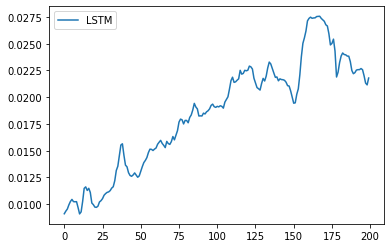

In [17]:
error.plot()

<AxesSubplot:>

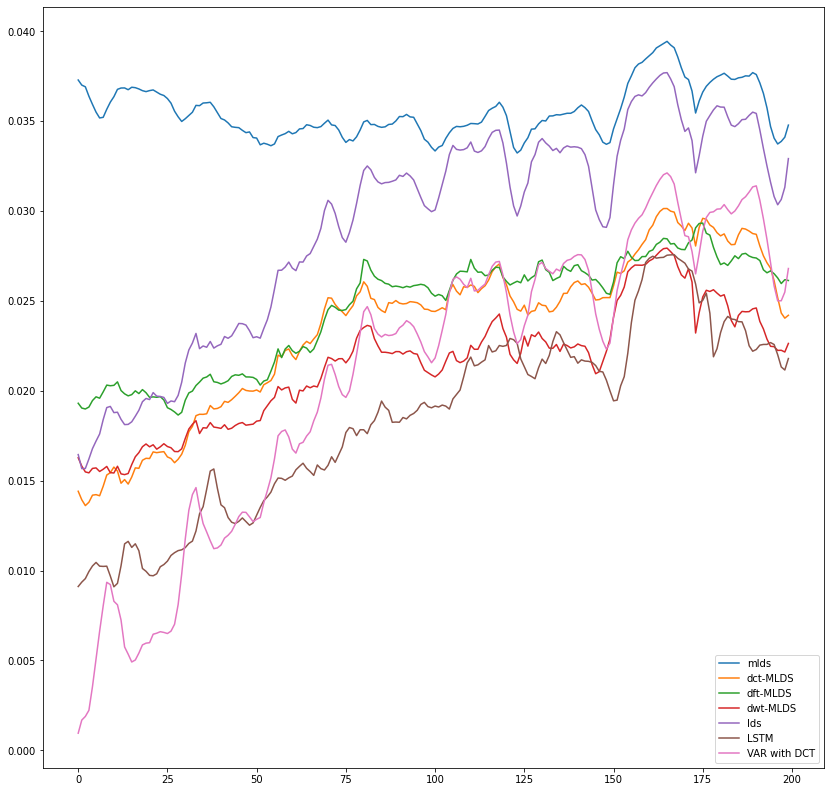

In [18]:
sst_err = sio.loadmat('data/sst_err.mat')
df1 = pd.DataFrame(np.transpose(sst_err['err_dct']), index=error.index, columns=["dct-MLDS"])
df2 = pd.DataFrame(np.transpose(sst_err['err_dft']), index=error.index, columns=["dft-MLDS"])
df3 = pd.DataFrame(np.transpose(sst_err['err_dwt']), index=error.index, columns=["dwt-MLDS"])
df4 = pd.DataFrame(np.transpose(sst_err['err_lds']), index=error.index, columns=["lds"])
df5 = pd.DataFrame(np.transpose(sst_err['err_mlds']), index=error.index, columns=["mlds"])
ltar_err = pd.read_csv("data/ltar_err.csv")
del ltar_err['Unnamed: 0']
df = pd.concat([df5, df1, df2, df3, df4, error, ltar_err], axis=1)
df.plot(figsize=(14, 14))

<AxesSubplot:>

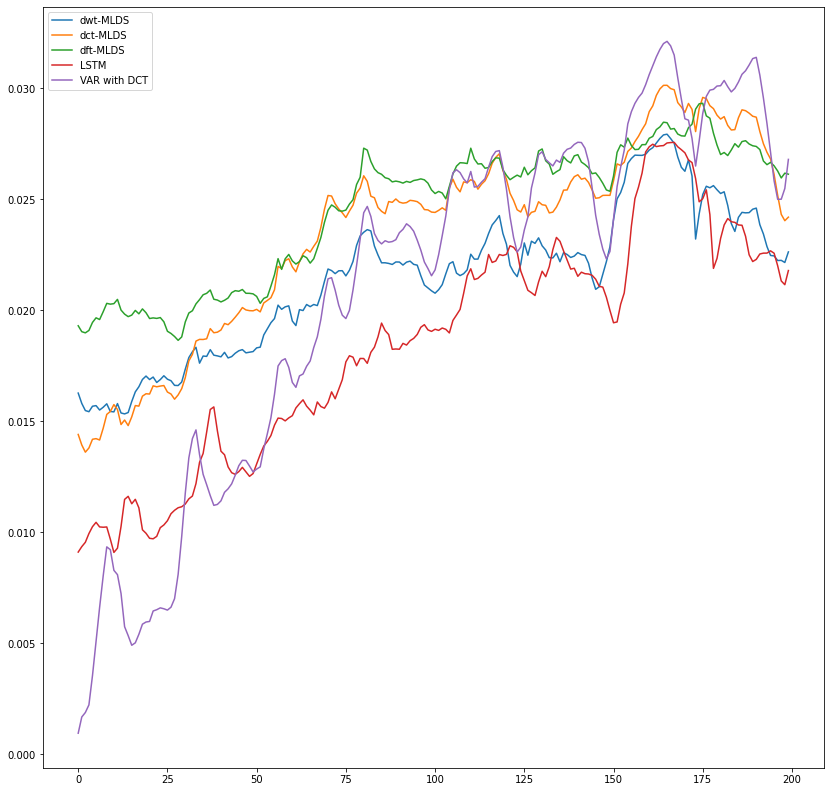

In [19]:
df = pd.concat([df3, df1, df2, error, ltar_err], axis=1)
df.plot(figsize=(14, 14))

<AxesSubplot:>

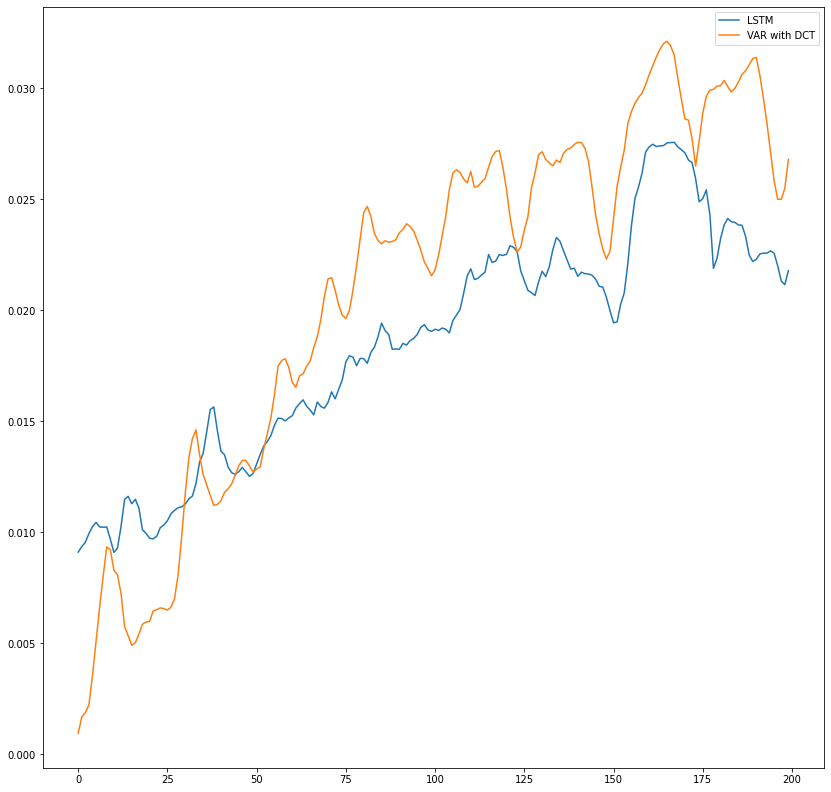

In [20]:
df = pd.concat([error, ltar_err], axis=1)
df.plot(figsize=(14, 14))